In [ ]:
!pip install pydot
!pip install pydotplus
!apt install graphviz

# Keras
Mediante la librería **Tensorflow** se pueden definir, entrenar y validar modelos de *Machine Learning*. Para ello hay que definir las entradas del modelo, sus variables (*parámetros*), el algoritmo de optimización y la función de coste. Si bien estas tareas no entrañan una dificultad elevada, el proceso es tedioso.

**Keras**, un API de alto nivel para construir y entrenar modelos en Tensorflow nos ofrece las mismas posibilidades aunque a un nivel de abstracción mayor, facilitando la tarea.

Para comprobar su funcionamiento, vamos a construir y entrenar algunos modelos para resolver problemas clásicos de aprendizaje supervisado.

## Caso de estudio: precio de las casas de Boston

Este conjunto de datos es bien conocido entre la comunidad. Se encuentra disponible en la librería *Scikit-Learn*. El conjunto de datos cuenta con 13 *features* numéricas sin estandarizar. La variable de salida es el precio en miles de dólares.

In [1]:
from sklearn.datasets import load_boston
from sklearn.utils import shuffle
boston = load_boston()
X, y = shuffle(boston.data, boston.target, random_state=1337)

train_validation_test_split()

**Keras** nos permite crear un modelo de aprendizaje de tipo red neuronal artificial. La red más sencilla es aquella compuesta por una capa de entrada, una de salida y varias capas ocultas. Para construir una red de estas características con **Keras** podemos usar el tipo `Sequential` e ir añadiendo las distintas capas.

In [23]:
import tensorflow as tf
tf.keras.backend.clear_session()

def generate_model_boston():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(X.shape[1],)),
        tf.keras.layers.Dense(16),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='relu'),
    ])

model_boston = generate_model_boston()
print(model_boston.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                224       
_________________________________________________________________
re_lu (ReLU)                 (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                204       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________
None


Ademas de la función `.summary()` que nos devuelve una representación textual de la red para poder imprimirla por pantalla, tenemos la posibilidad de representar la red gráficamente:

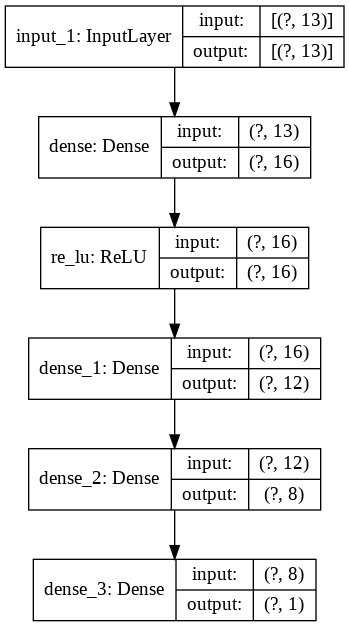

In [24]:
from keras.utils import plot_model

plot_model(model_boston, show_shapes=True)

Una vez definido el modelo hay que compilarlo para poder usarlo. Además, en el momento de la compilación del modelo tenemos que definir la **función de coste**, el **optimizador** y las **métricas** que queremos calcular. A partir de este momento ya podemos entrenar el modelo mediante `fit()` alimentándolo con el conjunto de datos de entrenamiento. Observa que el propio método de ajuste `fit()` tiene un parámetro para realizar el split en entrenamiento y test. Date cuenta también que no estamos utilizando *batches*, sino el conjunto de datos completo en cada *epoch* del entrenamiento.

In [29]:
with tf.device('/device:GPU:1'):
    tf.keras.backend.clear_session()
    model_boston = generate_model_boston()
    model_boston.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.mean_squared_error,
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.RootMeanSquaredError()
        ]
    )
    history_boston = model_boston.fit(X, y, epochs=35, verbose=0, validation_split=0.2)

La librería **Keras** también nos permite validar el modelo de forma muy sencilla, ejecutando `evaluate()`. Si bien en este ejemplo estamos usando el dataset completo, esta función sería útil si nos hubiésemos guardado un conjunto de test.

In [30]:
model_boston.evaluate(X, y)

16/16 [==============================] - 0s 3ms/step - loss: 59.4328 - mean_absolute_error: 5.2643 - root_mean_squared_error: 7.7093


[59.43280792236328, 5.26426362991333, 7.709267616271973]

También podemos usar la información histórica que devuelve el proceso de ajuste (método `fit()`) para representar gráficamente cómo evoluciona el valor de la función de pérdida así como otras métricas tanto para el conjunto de datos de entrenamiento como para el de validación.

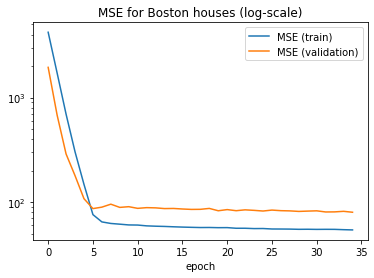

In [32]:
import matplotlib.pyplot as plt

plt.plot(history_boston.history['loss'], label='MSE (train)')
plt.plot(history_boston.history['val_loss'], label='MSE (validation)')
plt.title('MSE for Boston houses (log-scale)')
plt.xlabel('epoch')
plt.legend(loc="upper right")
plt.yscale('log')
plt.show()

Podemos hacer lo mismo con el resto de métricas de evaluación que configuramos en el momento de compilación del modelo. En este caso representamos la evolución del MAE tanto para entrenamiento como para validación.

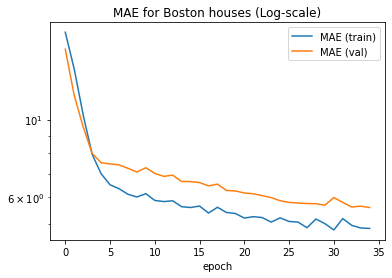

In [22]:
plt.plot(history.history['mean_absolute_error'], label='MAE (train)')
plt.plot(history.history['val_mean_absolute_error'], label='MAE (val)')
plt.title('MAE for Boston houses (Log-scale)')
plt.xlabel('epoch')
plt.legend(loc="upper right")
plt.yscale('log')
plt.show()

### Entrenamiento por lotes para reducir el *overfitting*
Podemos observar que las curvas de entrenamiento y validación se cruzan alrededor del *epoch* 12, indicando un sobreajuste del modelo. Esto es normal con las **redes neuronales artificiales** y, además, no hemos utilizado entrenamiento por lotes. Esto provoca que en cada *epoch* se utilice el dataset completo para ajustar los pesos, dando lugar al **overfitting**. Vamos a estudiar cómo afecta el tamaño del lote al sobreajuste del modelo

En primer lugar vamos a crear una función para dibujar la gráfica de la evolución de las métricas de calidad, así es más cómodo:

In [38]:
def plot_train_val(history, metric='loss', y_scale='linear'):
    plt.plot(history.history[metric], label=metric + ' (train)')
    plt.plot(history.history['val_' + metric], label=metric + ' (val)')
    plt.title(f'{metric} ({y_scale}-scale)')
    plt.xlabel('epoch')
    plt.legend(loc="upper right")
    plt.yscale(y_scale)
    plt.show()

Ahora vamos a reajustar el modelo utilizando entrenamiento por lotes. Para ello proporcionaremos el tamaño del lote al parámetro `batch_size` del método `fit()`:

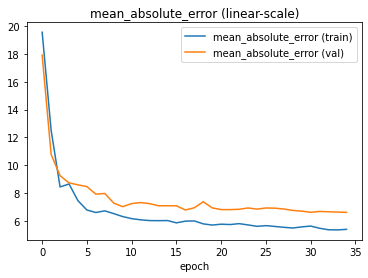

9.164935111999512


In [45]:
with tf.device('/device:GPU:1'):
    tf.keras.backend.clear_session()
    model_boston = generate_model_boston()
    model_boston.compile(
        optimizer='adam',
        loss=tf.keras.losses.mean_squared_error,
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.RootMeanSquaredError()
        ]
    )
    history = model_boston.fit(X, y, epochs=35, batch_size=50, verbose=0, validation_split=0.2)
    plot_train_val(history, metric='mean_absolute_error')
    print(history.history['val_root_mean_squared_error'][-1])

## Caso de estudio: MNIST

El siguiente dataset que vamos a trabajar es el clásico MNIST de dígitos manuscritos. Es un problema de clasificación que consiste en identificar el dígito de 0 a 9 analizando la imagen escaneada.

### API funcional vs. secuencial de Keras
En el ejemplo anterior hemos utilizado la *API secuencial* de Keras para definir el modelo. Esta API obtiene su nombre de la forma de construir los modelos añadiendo capas, una detrás de otra. Aunque muy sencilla de utilizar, esta API tiene un gran inconveniente, y es que los modelos definidas con ella **siempre son modelos lineales**, es decir, una secuencia interconectada de capas desde la entrada a la salida.

*Keras* nos ofrece una alternativa mucho más flexible que permite diseñar redes como un grafo acíclico dirigido: la **API funcional**. Vamos a ver cómo se usa esta API definiendo un modelo para resolver el problema de clasificación que se nos plantea.

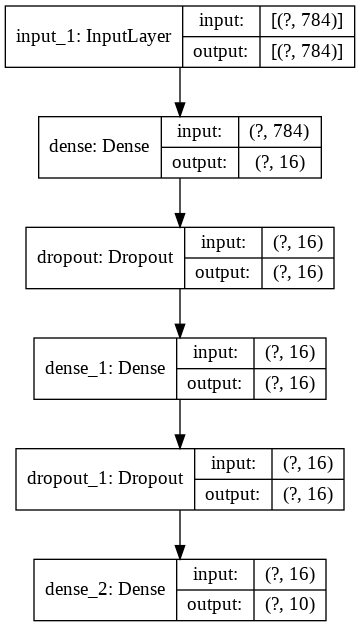

In [81]:
tf.keras.backend.clear_session()

def generate_model_mnist():
    inputs = tf.keras.Input(shape=(784,)) # Las imágenes de MNIST son de 28x28 píxeles

    x = tf.keras.layers.Dense(16, activation='relu')(inputs) # Primera capa densa conectada a 'inputs'
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x) # Segunda capa densa conectada a la primera 'x'
    x = tf.keras.layers.Dropout(0.1)(x)

    outputs = tf.keras.layers.Dense(10, activation='softmax')(x) # Capa de salida con 10 neuronas, una por clase
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="mnist")

plot_model(generate_model_mnist(), show_layer_names=True, show_shapes=True)

Como podemos observar, la forma de construirse que tiene el modelo nos permite topologías no lineales, varias entradas, etc. Procedemos ahora a cargar el *dataset*. Hacemos una normalización de los valores de las variables para pasar de un nivel de escala de grises de 0 a 255 a un valor continuo entre 0 y 1.

In [82]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

Ya solo nos queda compilar y entrenar el modelo. Es interesante recalcar que, dado que el problema es de clasificación, tenemos que usar una función de pérdida adecuada para este tipo de problemas. En nuestro caso usaremos **entropía cruzada categórica**.

Epoch 1/15
375/375 [==============================] - 2s 6ms/step - loss: 1.7001 - accuracy: 0.7674 - val_loss: 1.5674 - val_accuracy: 0.8953
Epoch 2/15
375/375 [==============================] - 1s 3ms/step - loss: 1.6050 - accuracy: 0.8574 - val_loss: 1.5630 - val_accuracy: 0.8980
Epoch 3/15
375/375 [==============================] - 1s 3ms/step - loss: 1.5920 - accuracy: 0.8699 - val_loss: 1.5442 - val_accuracy: 0.9167
Epoch 4/15
375/375 [==============================] - 1s 3ms/step - loss: 1.5841 - accuracy: 0.8771 - val_loss: 1.5458 - val_accuracy: 0.9145
Epoch 5/15
375/375 [==============================] - 1s 3ms/step - loss: 1.5817 - accuracy: 0.8796 - val_loss: 1.5457 - val_accuracy: 0.9145
Epoch 6/15
375/375 [==============================] - 1s 3ms/step - loss: 1.5792 - accuracy: 0.8821 - val_loss: 1.5533 - val_accuracy: 0.9077
Epoch 7/15
375/375 [==============================] - 1s 4ms/step - loss: 1.5780 - accuracy: 0.8833 - val_loss: 1.5497 - val_accuracy: 0.9108
Epoch 

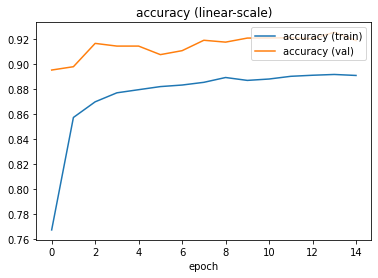

In [83]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    model_mnist = generate_model_mnist()
    model_mnist.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
        metrics=['accuracy']
    )
    history = model_mnist.fit(x_train, y_train, batch_size=128, epochs=15, validation_split=0.2)
    plot_train_val(history, metric='accuracy')

In [ ]:
plot_train_val(history, metric='accuracy')

Evaluamos el modelo con el conjunto de datos de test:

In [84]:
from sklearn.metrics import classification_report
import numpy as np

with tf.device('/device:GPU:0'):
    y_pred = np.argmax(model_mnist.predict(x_test, batch_size=64, verbose=0), axis=1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       980
           1       0.94      0.99      0.96      1135
           2       0.91      0.93      0.92      1032
           3       0.95      0.86      0.91      1010
           4       0.89      0.94      0.92       982
           5       0.90      0.83      0.87       892
           6       0.91      0.95      0.93       958
           7       0.95      0.91      0.93      1028
           8       0.92      0.88      0.90       974
           9       0.89      0.91      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



## Caso de estudio: calidad de los vinos
En esta ocasión tenemos que predecir la nota (0 a 10) que un experto catador otorgará a un vino en función de sus propiedades fisicoquímicas. El conjunto de datos está incluido en **Tensorflow**.

In [88]:
import tensorflow_datasets as tfds
ds, ds_info = tfds.load(
    'wine_quality',
    split='train',
    shuffle_files=True,
    with_info=True,
)
print(ds_info)

tfds.core.DatasetInfo(
    name='wine_quality',
    version=1.0.0,
    description='Two datasets were created, using red and white wine samples.
The inputs include objective tests (e.g. PH values) and the output is based on sensory data
(median of at least 3 evaluations made by wine experts).
Each expert graded the wine quality
between 0 (very bad) and 10 (very excellent).
Several data mining methods were applied to model
these datasets under a regression approach. The support vector machine model achieved the
best results. Several metrics were computed: MAD, confusion matrix for a fixed error tolerance (T),
etc. Also, we plot the relative importances of the input variables (as measured by a sensitivity
analysis procedure).

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine.
For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].
Due to privacy and logistic issues, only physicochemical (inputs) and sensor

Convertimos a Pandas Dataframe para que sea más cómodo de procesar.

In [91]:
from sklearn.utils import shuffle
raw_data = tfds.as_dataframe(ds, ds_info)
raw_data = shuffle(raw_data)
Y = raw_data['quality']
X = raw_data.drop('quality', axis=1)

En primer lugar tendríamos que normalizar/estandarizar las variables de entrada. Vamos a utilizar una capa de **Keras** que hace precisamente eso, por lo cual integraremos la normalización directamente en el modelo, justo a continuación de la salida.

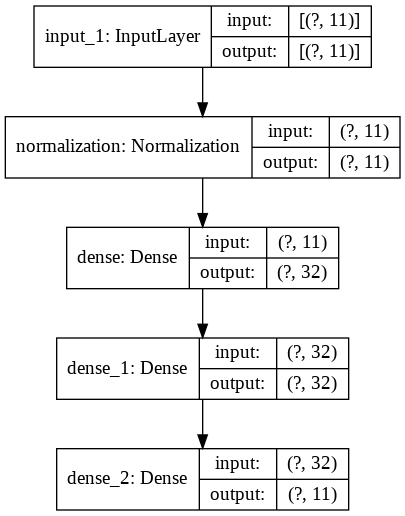

In [101]:
tf.keras.backend.clear_session()

def generate_model_wines():
    inputs = tf.keras.layers.Input((11,))
    normalize = tf.keras.layers.experimental.preprocessing.Normalization()(inputs)
    x = tf.keras.layers.Dense(32, activation='tanh')(normalize)
    x = tf.keras.layers.Dense(32, activation='tanh')(x)
    outputs = tf.keras.layers.Dense(11, activation='softmax')(x) # Notas de 0 a 10, ambas incluidas
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="wine_quality")

plot_model(generate_model_wines(), show_layer_names=True, show_shapes=True)

Epoch 1/15
245/245 [==============================] - 1s 4ms/step - loss: 2.1194 - accuracy: 0.4385 - val_loss: 2.1001 - val_accuracy: 0.4439
Epoch 2/15
245/245 [==============================] - 1s 3ms/step - loss: 2.0937 - accuracy: 0.4500 - val_loss: 2.0995 - val_accuracy: 0.4439
Epoch 3/15
245/245 [==============================] - 1s 3ms/step - loss: 2.0934 - accuracy: 0.4500 - val_loss: 2.0994 - val_accuracy: 0.4439
Epoch 4/15
245/245 [==============================] - 1s 3ms/step - loss: 2.0932 - accuracy: 0.4500 - val_loss: 2.0993 - val_accuracy: 0.4439
Epoch 5/15
245/245 [==============================] - 1s 3ms/step - loss: 2.0931 - accuracy: 0.4500 - val_loss: 2.0993 - val_accuracy: 0.4439
Epoch 6/15
245/245 [==============================] - 1s 3ms/step - loss: 2.0930 - accuracy: 0.4502 - val_loss: 2.0992 - val_accuracy: 0.4439
Epoch 7/15
245/245 [==============================] - 1s 3ms/step - loss: 2.0930 - accuracy: 0.4502 - val_loss: 2.0992 - val_accuracy: 0.4439
Epoch 

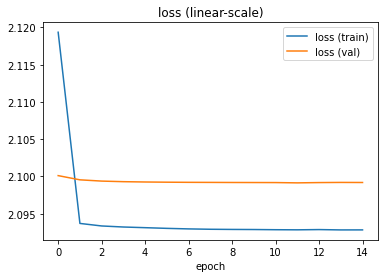

In [102]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    model_wines = generate_model_wines()
    model_wines.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.001),
        metrics=['accuracy']
    )
    history = model_wines.fit(X.values, Y.values, batch_size=16, epochs=15, verbose=1, validation_split=0.2)
    plot_train_val(history)

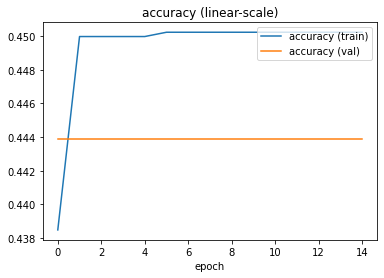

In [103]:
plot_train_val(history, metric='accuracy')

### Pipelines y variables de entrada

Podemos observar que planteando el problema como clasificación no obtenemos buenos resultados. Hay que pensar que la nota que se asigna a un vino tiene un orden, ya que no es lo mismo equivocarse prediciendo una nota de 2 cuando la real era un 10, que predecir un 9. Es por ello que vamos a plantear el problema como si de una regresión se tratase, devolviendo una salida continua que representa la votación predicha por el modelo.

Además, vamos a aprovechar este cambio para plantear el uso de *pipelines* para conectar los *datasets* al modelo, además de utilizar una entrada individual por cada una de las *features* del *dataset*.

En primer lugar, cargamos el conjunto de datos `wine_quality` utilizando tfds.load(), y convertimos la variable objetivo en `float`, ya que ahora el problema será de regresión y no de clasificación. A continuación, barajamos el conjunto de datos y lo dividimos en conjuntos de entrenamiento y de test. Tomamos los primeros `test_size` observaciones como la división de entrenamiento, y el resto como la división de test. Todo ello lo hacemos utilizando un **pipeline** de *Tensorflow*:

In [105]:
to_regression = lambda x, y: (x, tf.cast(y, tf.float32))

def get_train_and_test_splits(train_size, batch_size=1):
    dataset = (
        tfds.load(name="wine_quality", as_supervised=True, split="train")
        .map(to_regression)
        .prefetch(buffer_size=dataset_size)  # El dataset es pequeño y cabe entero en memoria
        .cache()
    )

    train_dataset = (
        dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size)
    )
    test_dataset = dataset.skip(train_size).batch(batch_size)

    return train_dataset, test_dataset

Como hemos dicho antes, vamos a construir un modelo en el cual cada *feature* es una entrada distinta del mismo. Para ello tenemos que darle nombres a las entradas. El resto del modelo será similar al que hemos definido antes, solo que ahora la capa de salida constará de una única neurona con una función de activación continua.

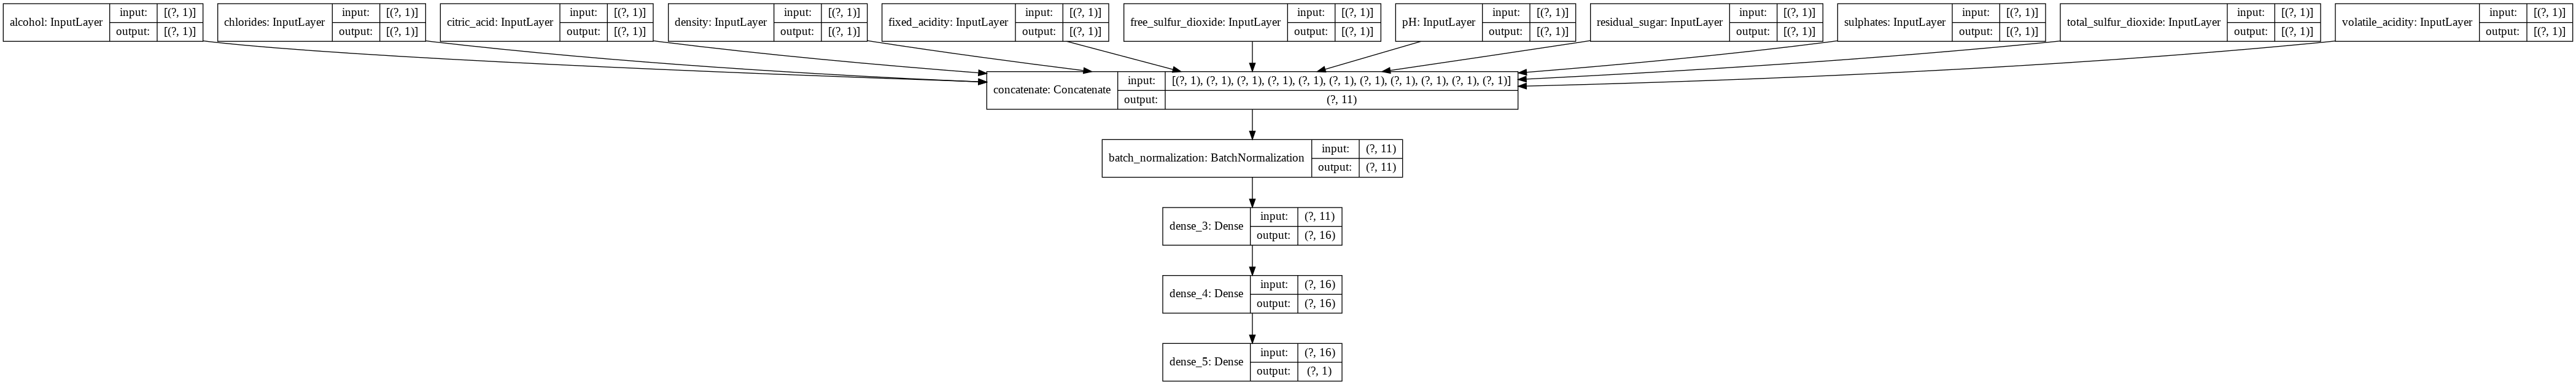

In [106]:
from tensorflow import keras
from tensorflow.keras import layers

FEATURE_NAMES = [
    "fixed_acidity",
    "volatile_acidity",
    "citric_acid",
    "residual_sugar",
    "chlorides",
    "free_sulfur_dioxide",
    "total_sulfur_dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]


def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(1,), dtype=tf.float32
        )
    return inputs

def regression_wine():
    inputs = create_model_inputs()
    input_values = [value for _, value in sorted(inputs.items())]
    features = keras.layers.concatenate(input_values)
    features = layers.BatchNormalization()(features)
    for units in [16, 16]:
        features = layers.Dense(units, activation="sigmoid")(features)
    outputs = layers.Dense(units=1, activation='relu')(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model
plot_model(regression_wine(), show_layer_names=True, show_shapes=True)

Vamos a hacer una partición de entrenamiento y test en 80% y 20%, respectivamente.

In [107]:
dataset_size = 4898
batch_size = 256
train_size = int(dataset_size * 0.80)
train_dataset, test_dataset = get_train_and_test_splits(train_size, batch_size)

Y procedemos al entrenamiento y validación del modelo construido.

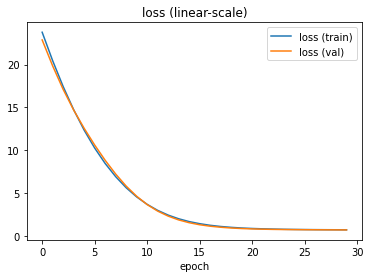

In [109]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    reg_wines = regression_wine()
    reg_wines.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(0.001),
        metrics=[keras.metrics.RootMeanSquaredError()],
    )
    history = reg_wines.fit(train_dataset, epochs=30, validation_data=test_dataset, verbose=0)
    plot_train_val(history)

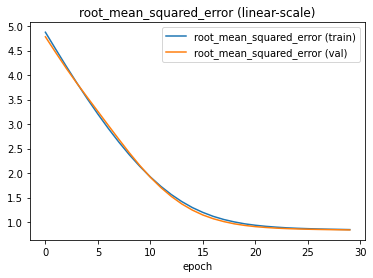

In [111]:
plot_train_val(history, metric='root_mean_squared_error')

---

Creado por **Raúl Lara Cabrera** (raul.lara@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">